# Evaluating Scenario Outcomes With A/B Testing

## Introduction
A/B testing is a very common framework for comparing the outcomes of two scenarios. These could be two brand new scenarios or a new idea that you want to test against your current strategy. A/B testing will not outright tell you which scenario is better but it will tell you whether there is a statistical difference between the two. You can then consult other performance metrics to judge their effectiveness. 

This project will investigate two sets of data with different inputs and goals. The first is data from a mobile game called Cookie Cats that looks at retention rate and the second is data from an auction platform that looks at the participation rate of a questionnaire.

### Case Study 1: Cookie Cats

Cookie Cats is a classic mobile puzzle game where you must connect three matching icons to get points and progress through the game's puzzles. As puzzles are completed users will level up their accounts and encounter more difficult puzzles. At certain levels there are content gates that require the user to wait a certain amount of time or make an in-game purchase to continue solving puzzles and level up further. 

The two scenarios we are analyzing for this case study are: the first content gate being at level 30 or at level 40. The three metrics we will be comparing between the two gate points are: the total number of rounds that the user played and whether they have returned to the game one or seven days after the original installation.

#### Data and Exploratory Analysis

In [8]:
#Import important packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

Once the data was loaded from .csv format it was inspected to determine if cleaning up needs to be done prior to the analysis. There are 90189 unique users and 5 categories of data for each user. The categories (columns) that are included are:
* userid: The unique user ID number
* version: Which level the content gate was placed at  
    * gate_30: The users who were content gated at level 30
    * gate_40: The users who were content gated at level 40
* sum_gamerounds: The total number of rounds the user has played.
* retention_1: Whether or not the user returned to the game 1 day after installation. 
* retention_7: Whether or not the user returned to the game 7 days after installation. 

In [2]:
# Load data from the .csv into a pandas data frame.
ccats = pd.read_csv('cookie_cats.csv')
ccats

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


The data was checked for null or missing values to ensure that no errors would occur later on and to check for completeness of the source data. 

In [3]:
#Check data set for missing or null values
ccats.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

The range of the game rounds was then checked to ensure that it was consistent and that there were no outliers. There was in fact one record with 50,000 game rounds recorded that was a clear outlier. It was removed so that it would not skew the rest of the data. Once that was done the range was much more consistent and very visually similar between both level gates.

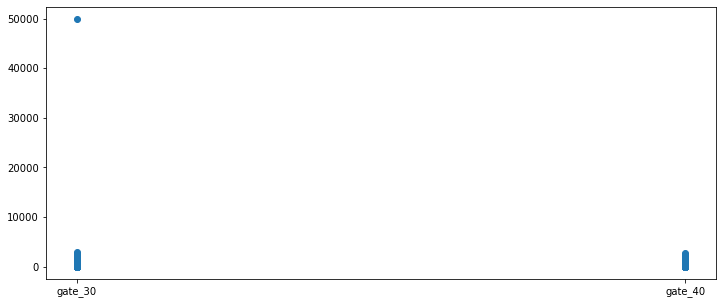

In [4]:
# Plot the sum_gameround distribution ofr each version
plt.figure(figsize = (12,5))
plt.scatter(x = ccats['version'], y = ccats['sum_gamerounds'])

In [5]:
# Remove all records with more than 10,000 total game rounds
ccats = ccats[ccats.sum_gamerounds < 10000]

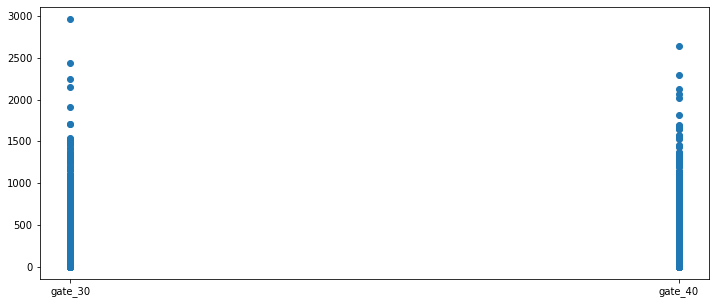

In [6]:
# Plot the sum_gameround distribution ofr each version
plt.figure(figsize = (12,5))
plt.scatter(x = ccats['version'], y = ccats['sum_gamerounds'])

The distribution of the number of game rounds played was also plotted to get a more detailed look at how this metric differed from on scenario to the next. A log y-axis was used to show this distribution more clearly. There was very little divergence between the two gates until you reached the upper limits of the games rounds played. This makes sense as it is less likely for users to reach those totals and therefore more divergence is expected because those events occur less often. 

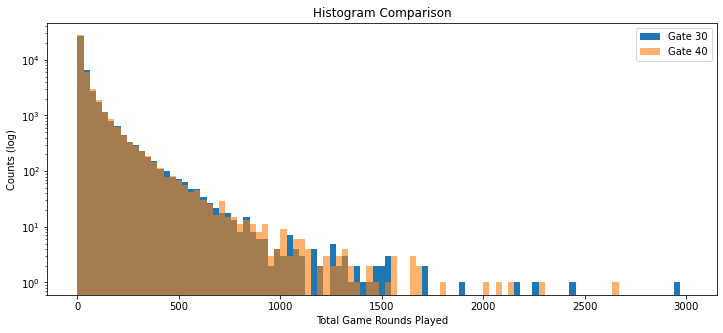

In [9]:
plt.figure(figsize = (12,5))
numBins = np.linspace(1, 3000, 100)
plt.hist(ccats['sum_gamerounds'].where(ccats['version'] == 'gate_30'), numBins, label = 'Gate 30')
plt.hist(ccats['sum_gamerounds'].where(ccats['version'] == 'gate_40'), numBins, label = 'Gate 40', alpha = 0.6)
plt.title('Histogram Comparison')
plt.ylabel('Counts (log)')
plt.xlabel('Total Game Rounds Played')
plt.yscale('log')
plt.legend()
plt.show()

A visual inspection of the retention columns was then conducted for two purposes. The first was to ensure that there was not a class imbalance between the two version types at all retention levels. The second was to see if there were any obvious differences between the 4 classes of users that could be used to double check the numeric analysis that will follow later in this project. 

In [10]:
# Creating variables for number of users in each of the 4 categories

# Number of users in version: gate_30 who returned after 1 day
thirtyOneT = len(ccats.loc[(ccats['version'] == 'gate_30') & (ccats['retention_1'] == True)])
# Number of users in version: gate_40 who returned after 1 day
fortyOneT = len(ccats.loc[(ccats['version'] == 'gate_40') & (ccats['retention_1'] == True)])
# Number of users in version: gate_30 who did not return after 1 day
thirtyOneF = len(ccats.loc[(ccats['version'] == 'gate_30') & (ccats['retention_1'] == False)])
# Number of users in version: gate_40 who did not return after 1 day
fortyOneF = len(ccats.loc[(ccats['version'] == 'gate_40') & (ccats['retention_1'] == False)])

# Number of users in version: gate_30 who returned after 7 days
thirtySevenT = len(ccats.loc[(ccats['version'] == 'gate_30') & (ccats['retention_7'] == True)])
# Number of users in version: gate_40 who returned after 7 days
fortySevenT = len(ccats.loc[(ccats['version'] == 'gate_40') & (ccats['retention_7'] == True)])
# Number of users in version: gate_30 who did not return after 7 days
thirtySevenF = len(ccats.loc[(ccats['version'] == 'gate_30') & (ccats['retention_7'] == False)])
# Number of users in version: gate_40 who did not return after 7 days
fortySevenF = len(ccats.loc[(ccats['version'] == 'gate_40') & (ccats['retention_7'] == False)])

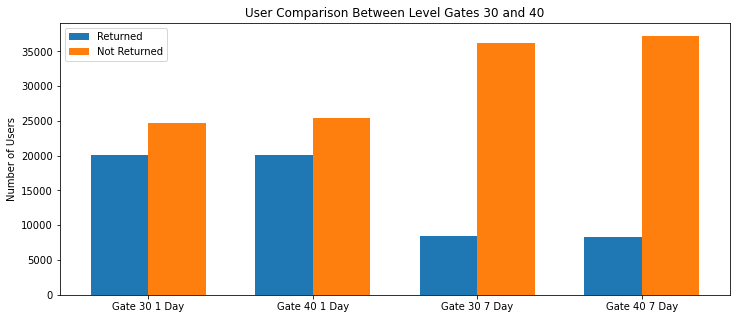

In [37]:
# Setting up the format variables for the bar graph
# Label names
labels = ['Gate 30 1 Day', 'Gate 40 1 Day', 'Gate 30 7 Day', 'Gate 40 7 Day']
# Array of returned user totals
trueGates = [thirtyOneT, fortyOneT, thirtySevenT, fortySevenT]
# Array of not returned iser totals
falseGates = [thirtyOneF, fortyOneF, thirtySevenF, fortySevenF]
# Bar width
width = 0.35
# Number of labels
labelLen = np.arange(len(labels))

# Creating the side-by-side bar graph
fig, ax = plt.subplots(figsize = (12,5))
gate1 = ax.bar(labelLen - width/2, trueGates, width, label = 'Returned')
gate2 = ax.bar(labelLen + width/2, falseGates, width, label = 'Not Returned')

# Graph elements
ax.set_ylabel('Number of Users')
ax.set_title('User Comparison Between Level Gates 30 and 40')
ax.set_xticks(labelLen)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

It is evident from this plot that the classes are evenly divided and that they both follow very similar trends when it comes to user retention and drop off between the one and seven day intervals. From this point we can't make any confident assumptions regarding which content level gate resulted in more retention or more game rounds played. This is where A/B tests truly shine. They can take very marginal differences between the outcomes of two scenarios and determine whether there is a statistically significant difference or not. 

#### Statistical Analysis

In [39]:
meanThirty = ccats.loc[(ccats['version'] == 'gate_30')].mean()[1]
meanForty = ccats.loc[(ccats['version'] == 'gate_40')].mean()[1]

print(f"The mean gamerounds for the level 30 gate vs the level 40 gate is: {round(meanThirty,3)} vs. {round(meanForty,3)}")

The mean gamerounds for the level 30 gate vs the level 40 gate is: 51.342 vs. 51.299


In [40]:
#Table showing retention rates for (gate30 ret 1), (gate40 ret 1), (gate30 ret 7), (gate40 ret 7)
totalThirty = len(ccats.loc[(ccats['version'] == 'gate_30')])
totalForty = len(ccats.loc[(ccats['version'] == 'gate_40')])

rateThirtyOne = round((thirtyOneT/totalThirty)*100,2)
rateThirtySeven = round((thirtySevenT/totalThirty)*100,2)

rateFortyOne = round((fortyOneT/totalForty)*100,2)
rateFortySeven = round((fortySevenT/totalForty)*100,2)

print(f"The 1 day retention rate for the level 30 gate vs the level 40 gate is: {rateThirtyOne}% vs. {rateFortyOne}%")
print(f"The 7 day retention rate for the level 30 gate vs the level 40 gate is: {rateThirtySeven}% vs. {rateFortySeven}%")

The 1 day retention rate for the level 30 gate vs the level 40 gate is: 44.82% vs. 44.23%
The 7 day retention rate for the level 30 gate vs the level 40 gate is: 19.02% vs. 18.2%


$$ H_0 : d = 0 \; \; \; \text{vs}\; \; \; H_1 : d \neq 0 $$

$$H_0: \; \; \text{ The difference between the two scenarios is 0.}\; $$
$$H_1: \; \; \text{ The difference between the two scenarios is not 0.}\; $$

In [14]:
# proportions z test is located inside statsmodels
from statsmodels.stats.proportion import proportions_ztest

In [15]:
meanGates = [meanThirty, meanForty]
meanObs =  [totalThirty, totalForty]
print(f"The p-value for the mean gamerounds between the control and moved users is: {proportions_ztest(meanGates, meanObs)[1]}")

The p-value for the mean gamerounds between the control and moved users is: 0.9258417189307235


In [16]:
retOneCount = [thirtyOneT, fortyOneT]
retOneObs =  [totalThirty, totalForty]
print(f"The p-value for the one day retention rate between the control and moved users is: {proportions_ztest(retOneCount, retOneObs)[1]}")

The p-value for the one day retention rate between the control and moved users is: 0.0739207603418346


The p-value is 0.0739 which means we cannot reject the null hypothesis based on the arbitrary industry standard cut-off of 0.05. There is no statistical difference between the one day retention rates of both scenarios.

In [17]:
retSevenCount = [thirtySevenT, fortySevenT]
retSevenObs =  [totalThirty, totalForty]
print(f"The p-value for the seven day retention rate between the control and moved users is: {proportions_ztest(retSevenCount, retSevenObs)[1]}")

The p-value for the seven day retention rate between the control and moved users is: 0.0015917731773993442


The p-value is 0.0016 which means we can reject the null hypothesis based on the arbitrary industry standard cut-off of 0.05. There is a statistical difference between the seven day retention rates of both scenarios.

### Conclusion

There was a 0.59% drop in one day retention rate between control group and the moved group. Through a proportional z-test it was determined that the difference between the two scenarios was not statistically different. With the data currently available we cannot say that there was a difference in the one day retention rate.

There was a 0.82% drop in seven day retention rate between control group and the moved group. Through a proportional z-test it was determined that the difference between the two scenarios was statistically different. With the data currently available we can say that there was a significant drop in the seven day retention rate.

In [18]:
adSmart = pd.read_csv('AdSmartABdata - AdSmartABdata.csv')
adSmart

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


In [19]:
adSmart.drop(['no'], axis = 1, inplace = True)
adSmart.rename(columns= {'yes': 'questionaire'}, inplace = True)

In [20]:
print(f"There were {adSmart.questionaire.value_counts()[1]} users that participated in the questionaire.")
print(f"There were {adSmart.questionaire.value_counts()[0]} users that did not participated in the questionaire.")

There were 572 users that participated in the questionaire.
There were 7505 users that did not participated in the questionaire.


In [21]:
adSmart.browser.value_counts()

Chrome Mobile                 4554
Chrome                        1492
Samsung Internet               824
Facebook                       764
Mobile Safari                  337
Chrome Mobile iOS               51
Mobile Safari UI/WKWebView      44
Pinterest                        3
Opera Mobile                     3
Firefox Mobile                   1
Puffin                           1
Opera Mini                       1
Android                          1
Edge Mobile                      1
Name: browser, dtype: int64

In [22]:
adSmart.browser.replace(['Chrome Mobile',
                         'Samsung Internet',
                         'Mobile Safari',
                         'Chrome Mobile iOS',
                         'Mobile Safari UI/WKWebView',
                         'Opera Mobile',
                         'Firefox Mobile',
                         'Android',
                         'Edge Mobile',
                         'Puffin'],'Mobile', inplace = True)

In [23]:
adSmart.browser.replace(['Chrome',
                         'Opera Mini'],'Desktop', inplace = True)

In [24]:
adSmart.browser.replace(['Facebook',
                         'Pinterest'],'Application', inplace = True)

In [26]:
adSmart.browser.value_counts()

Mobile         5817
Desktop        1493
Application     767
Name: browser, dtype: int64

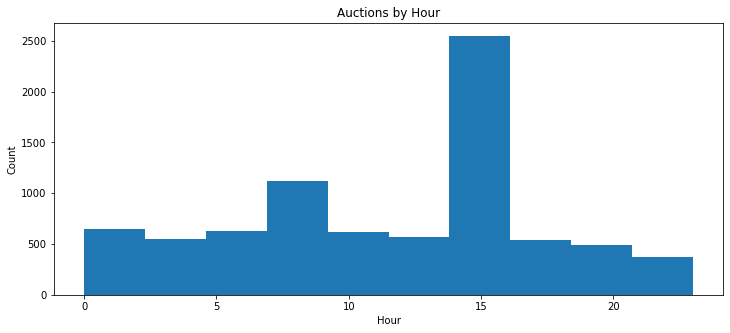

In [27]:
plt.figure(figsize = (12,5))
plt.hist(adSmart['hour'])
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Auctions by Hour')
plt.show()

In [28]:
adSmart.hour.replace([7, 8, 9, 10, 11, 12, 13, 14],'Morning', inplace = True)
adSmart.hour.replace([15, 16, 17, 18, 19, 20],'Evening', inplace = True)
adSmart.hour.replace([21, 22, 23, 24, 0, 1, 2, 3, 4, 5, 6],'Night', inplace = True)
adSmart.rename(columns= {'hour': 'timeOfDay'}, inplace = True)

In [29]:
adSmart.timeOfDay.value_counts()

Evening    3257
Morning    2626
Night      2194
Name: timeOfDay, dtype: int64

In [32]:
adSmart.drop(['device_make', 'platform_os'], axis =1, inplace = True)

KeyError: "['device_make' 'platform_os'] not found in axis"

In [31]:
adSmart

,auction_id,experiment,date,timeOfDay,browser,questionaire
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,Morning,Mobile,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,Morning,Mobile,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,Night,Desktop,0
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,Evening,Application,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,Evening,Mobile,0
...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,Morning,Mobile,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,Evening,Mobile,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,Morning,Mobile,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,Evening,Mobile,0


In [33]:
controlCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['experiment'] == 'control')])
exposedCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['experiment'] == 'exposed')])

controlObs = len(adSmart.loc[(adSmart['experiment']) == 'control'])
exposedObs = len(adSmart.loc[(adSmart['experiment']) == 'exposed'])

In [ ]:
rateControl = round((controlCount/controlObs)*100,2)
rateExposed = round((exposedCount/exposedObs)*100,2)
print(f"The participation rate for the control vs the exposed is: {rateControl}% vs. {rateExposed}%")

In [ ]:
partCount = [controlCount, exposedCount]
partObs =  [controlObs, exposedObs]
print(f"The p-value for the one day retention rate for the control and moved users is: {proportions_ztest(partCount, partObs)[1]}")

In [ ]:
morningCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['timeOfDay'] == 'Morning')])
eveningCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['timeOfDay'] == 'Evening')])
nightCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['timeOfDay'] == 'Night')])

morningObs = len(adSmart.loc[(adSmart['timeOfDay']) == 'Morning'])
eveningObs = len(adSmart.loc[(adSmart['timeOfDay']) == 'Evening'])
nightObs = len(adSmart.loc[(adSmart['timeOfDay']) == 'Night'])

In [ ]:
rateMorning = round((morningCount/morningObs)*100,2)
rateEvening = round((eveningCount/eveningObs)*100,2)
rateNight = round((nightCount/nightObs)*100,2)
print(f"The participation rate for different times of the day is:\n {rateMorning}% for the morning\n {rateEvening}% for the evening\n {rateNight}% for the night.")

In [ ]:
partENCount = [eveningCount, nightCount]
partENObs =  [eveningObs, nightObs]
proportions_ztest(partENCount, partENObs)

In [ ]:
desktopCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['browser'] == 'Desktop')])
mobileCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['browser'] == 'Mobile')])
appCount = len(adSmart.loc[((adSmart['questionaire']) == 1) & (adSmart['browser'] == 'Application')])

desktopObs = len(adSmart.loc[(adSmart['browser']) == 'Desktop'])
mobileObs = len(adSmart.loc[(adSmart['browser']) == 'Mobile'])
appObs = len(adSmart.loc[(adSmart['browser']) == 'Application'])

In [ ]:
rateDesktop = round((desktopCount/desktopObs)*100,2)
rateMobile = round((mobileCount/mobileObs)*100,2)
rateApp = round((appCount/appObs)*100,2)
print(f"The participation rate for different times of the day is:\n {rateDesktop}% on Desktop\n {rateMobile}% on Mobile\n {rateApp}% on Applications.")

In [ ]:
partMACount = [mobileCount, appCount]
partMAObs =  [mobileObs, appObs]
print(f"The p-value between mobile and application exposed participation is: {proportions_ztest(partMACount, partMAObs)[1]}")

In [ ]:
partDACount = [desktopCount, appCount]
partDAObs =  [desktopObs, appObs]
print(f"The p-value between desktop and application exposed participation is: {proportions_ztest(partDACount, partDAObs)[1]}")

In [ ]:
partDMCount = [desktopCount, mobileCount]
partDMObs =  [desktopObs, mobileObs]
print(f"The p-value between desktop and mobile exposed participation is: {proportions_ztest(partDMCount, partDMObs)[1]}")